# Harnessing Mean Reversion with Hurst Exponent: A QuantConnect Backtesting Guide

## Introduction

In the fast-paced world of algorithmic trading, mean reversion strategies have long been a favorite among traders. But what exactly is mean reversion, and how can you harness its power using modern tools? Enter QuantConnect, a cutting-edge platform that revolutionizes the way we develop, test, and deploy trading algorithms. In this article, we'll explore the fundamentals of mean reversion and guide you through building and backtesting a robust mean reversion trading algorithm using QuantConnect. Whether you're a seasoned quant or a novice trader, this guide will equip you with the knowledge and tools to create your own mean reversion strategy.


## Getting Started with QuantConnect

Before we dive into coding and backtesting our mean reversion strategy, let's walk through the process of registering on QuantConnect and creating a project.

### Step 1: Register on QuantConnect

1. **Visit the QuantConnect Website**: Go to [QuantConnect](https://www.quantconnect.com/).
2. **Sign Up**: Click on the "Sign Up" button at the top right corner of the homepage. You can sign up using your email, Google, or GitHub account.
3. **Complete Registration**: Follow the prompts to complete the registration process.

### Step 2: Create a New Project

Once you have registered and logged in, you'll need to create a new project where you can write and backtest your algorithm.

1. **Navigate to the Lab Environment**: After logging in, click on the "Lab" tab in the top navigation bar. This will take you to the lab environment where you can create and manage your projects.
2. **Create a New Algorithm**:
   - Click on the "Create new Algorithm" button.
   - Choose a template for your algorithm (you can start with a basic template).
   - Click "Create".

### Step 3: Set Up Your Project for Backtesting

With your project created, you can now start setting up your environment for backtesting your strategy.

1. **Open Your Project**: Click on the name of your newly created project to open it.
2. **Set Up the Algorithm File**: QuantConnect automatically creates a main algorithm file for you (usually named `main.py`). This is where you will write your trading algorithm code.
3. **Write Your Algorithm**: You can now start coding your mean reversion strategy. Refer to the step-by-step guide provided in this article to write and understand your algorithm.


## Building the Algorithm: Step by Step

### Step 1: Setting Up the Environment


In [ ]:
from AlgorithmImports import *

class MeanReversionAlgorithm(QCAlgorithm):
    def Initialize(self):
        self.SetStartDate(2017, 1, 1)
        self.SetEndDate(2024, 1, 1)
        self.SetCash(100000)
        self.AddEquity("SPY", Resolution.Daily)


Here, we're laying the groundwork for our algorithm. We're setting a 7-year backtesting period and starting with a $100,000 portfolio. We'll be trading SPY, the SPDR S&P 500 ETF Trust, which is a great proxy for the overall U.S. stock market.

### Step 2: Defining Parameters


In [ ]:
        self.lookback = 20
        self.std_dev_threshold = 2
        self.close_threshold = 0.2
        self.hurst_threshold = 0.5
        self.hurst_window = 100

        self.symbol = self.Securities["SPY"].Symbol
        self.window = RollingWindow[float](self.lookback)
        self.hurst_window_prices = RollingWindow[float](self.hurst_window)


These parameters are the secret sauce of our algorithm. Let's break them down:

- `lookback`: We're using a 20-day window to calculate our average and standard deviation.
- `std_dev_threshold`: We'll make trades when the price moves 2 standard deviations away from the mean.
- `close_threshold`: We'll close our position when the price moves within 0.2 standard deviations of the mean.
- `hurst_threshold`: The Hurst exponent helps us confirm if the market is truly mean-reverting.

### Step 3: Processing Data


In [ ]:
    def OnData(self, data):
        if not data.ContainsKey(self.symbol):
            return

        price = data[self.symbol].Close
        self.window.Add(price)
        self.hurst_window_prices.Add(price)

        if not self.window.IsReady or not self.hurst_window_prices.IsReady:
            return


This section is all about data handling. We're collecting closing prices and storing them in our rolling windows. We only proceed with our calculations when we have enough data.

### Step 4: Calculating Metrics


In [ ]:
        prices = list(self.window)
        hurst_prices = list(self.hurst_window_prices)

        hurst = self.calculate_hurst_exponent(hurst_prices)
        self.Debug(f"Hurst Exponent: {hurst}")

        mean = np.mean(prices)
        std_dev = np.std(prices)
        z_score = (price - mean) / std_dev

        self.Debug(f"Price: {price}, Mean: {mean}, Z-score: {z_score}, Hurst: {hurst}")


Now we're getting to the heart of our mean reversion strategy. We're calculating:

1. The Hurst exponent, which tells us if the market is trending or mean-reverting.
2. The mean and standard deviation of our price window.
3. The z-score, which tells us how many standard deviations away from the mean the current price is.

### Step 5: Trading Logic


In [ ]:
        if hurst < self.hurst_threshold:
            if z_score < -self.std_dev_threshold:
                self.SetHoldings(self.symbol, 1)
                self.Debug("BUY signal")
            elif z_score > self.std_dev_threshold:
                self.SetHoldings(self.symbol, -1)
                self.Debug("SELL signal")
        else:
            self.Debug("No trade: Hurst Exponent >= 0.5")

        if abs(z_score) <= self.close_threshold:
            self.Liquidate(self.symbol)
            self.Debug("Close position signal")


This is where the magic happens. We're:

1. Checking if the market is mean-reverting (Hurst < 0.5).
2. Buying when the price is significantly below the mean (negative z-score).
3. Selling when the price is significantly above the mean (positive z-score).
4. Closing our position when the price returns close to the mean.

### Step 6: Calculating the Hurst Exponent


In [ ]:
    def calculate_hurst_exponent(self, prices):
        lags = range(2, 20)
        tau = [np.sqrt(np.std(np.subtract(prices[lag:], prices[:-lag]))) for lag in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)
        return poly[0] * 2.0


The Hurst exponent is our secret weapon for confirming mean reversion. A value between 0 and 0.5 suggests mean reversion, while a value between 0.5 and 1 suggests a trending market.

## Running and Testing Your Strategy

Now that we've built our mean reversion algorithm, it's time for the exciting part - seeing it in action! Let's run our strategy and analyze the results.

### Backtesting

The first step is to backtest our algorithm. This involves running our strategy on historical data to see how it would have performed.

To run a backtest in QuantConnect:

1. Click on the "Backtest" button in the top-right corner of your algorithm page.
2. Set your backtest parameters (start date, end date, initial capital).
3. Click "Run Backtest".

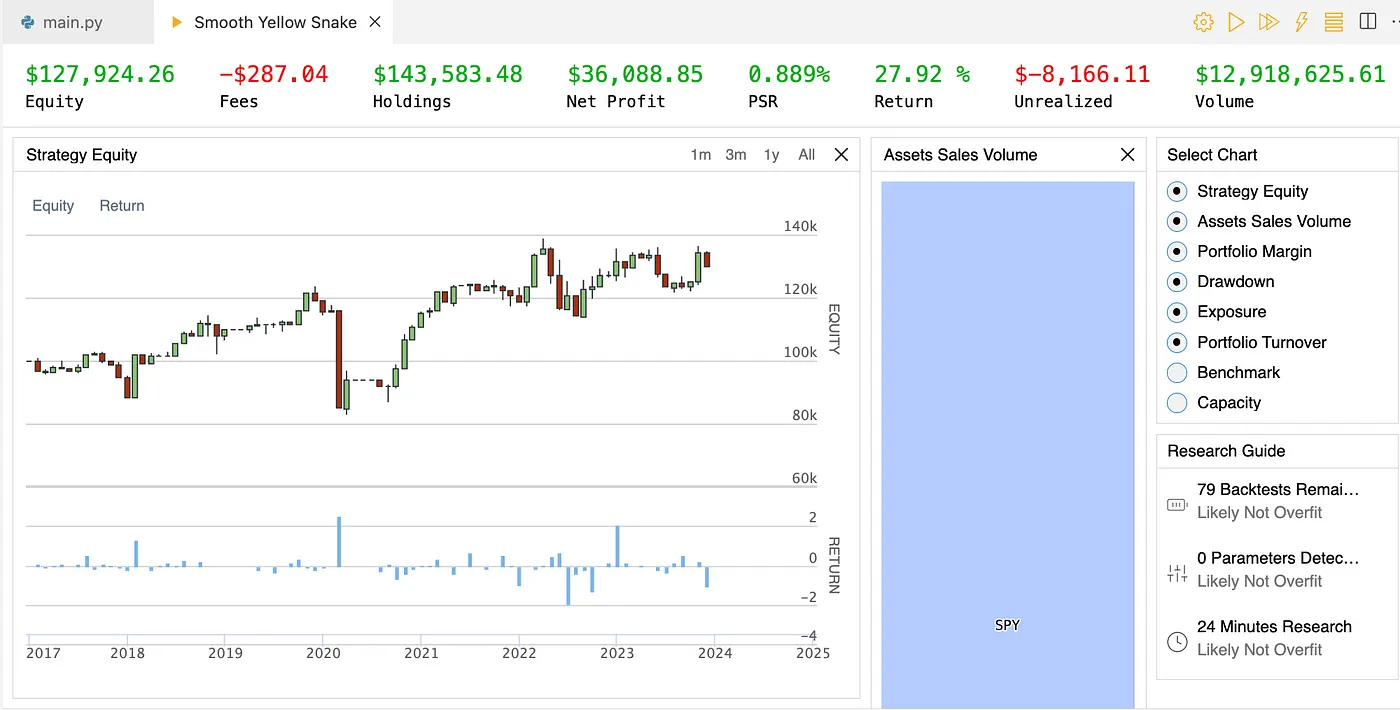

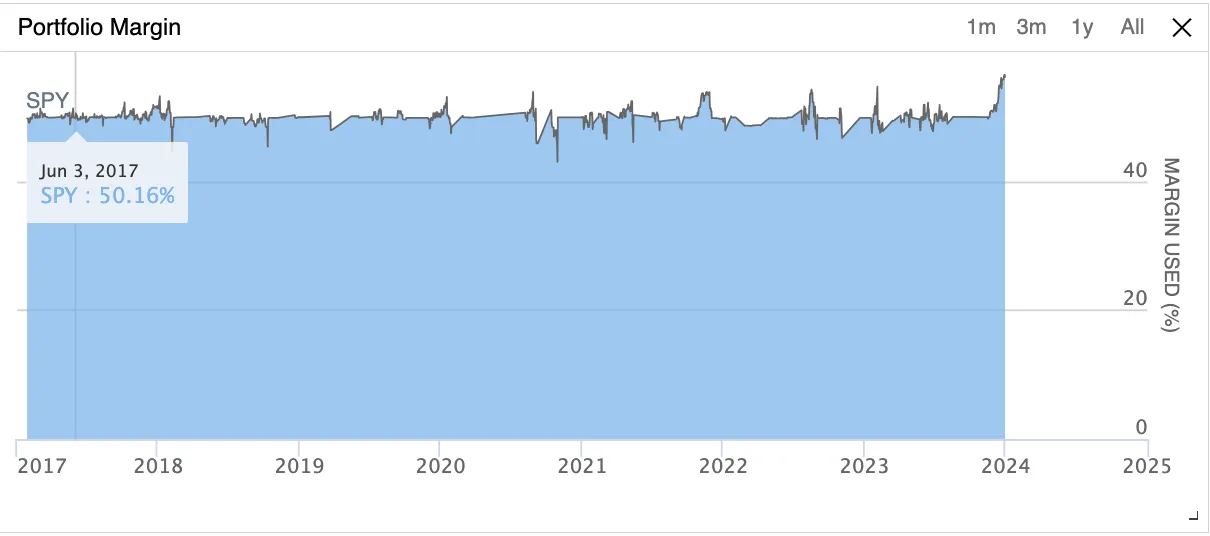

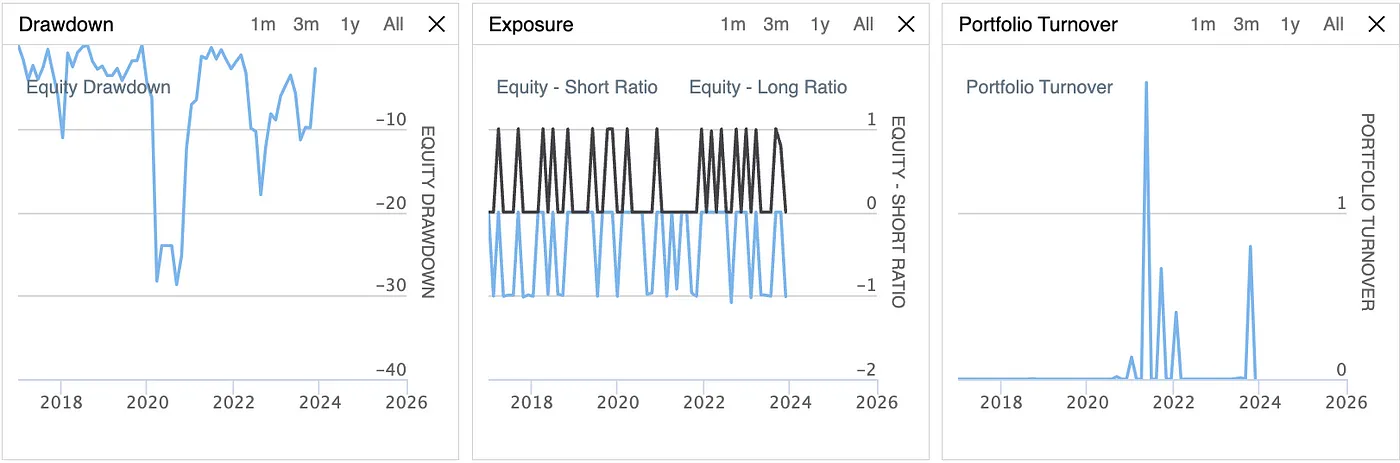

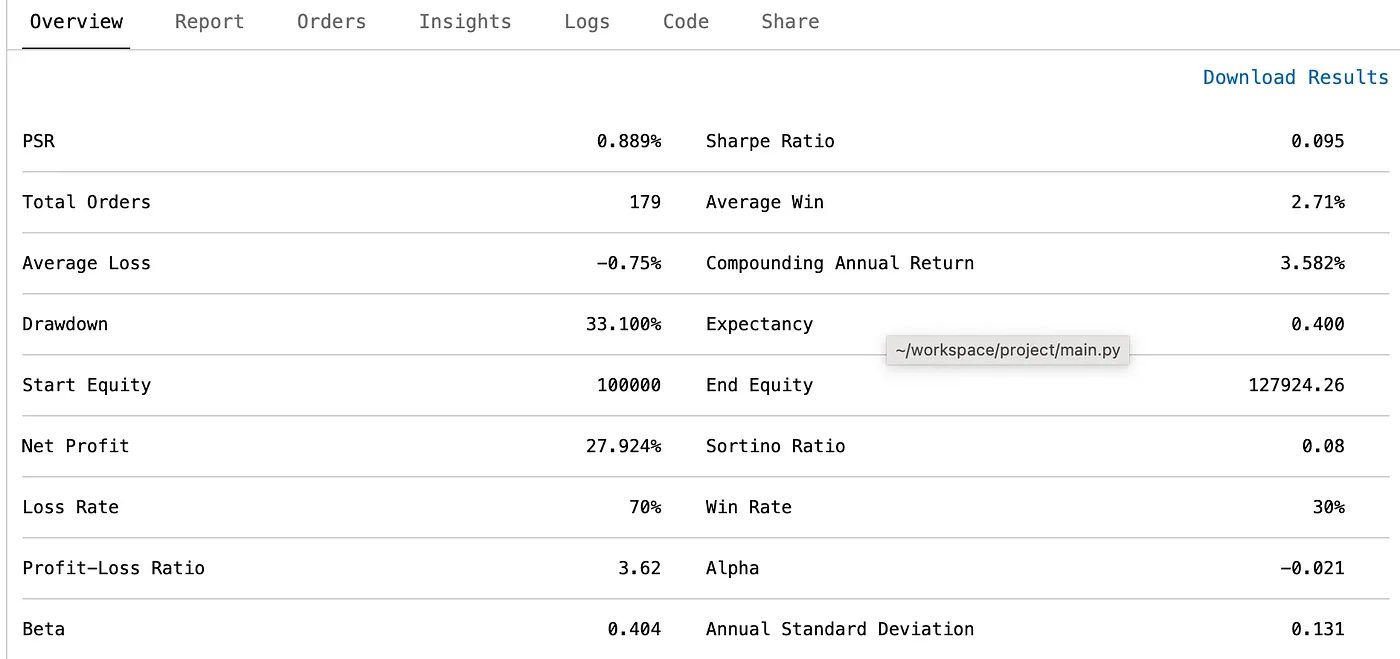

### Optimization

Based on our initial results, we can optimize our strategy. Some areas to focus on:

1. **Adjusting Parameters**: We might try different lookback periods or z-score thresholds.
2. **Fine-tuning Entry/Exit**: Perhaps we can improve our timing for entering and exiting trades.
3. **Risk Management**: We could implement stop-losses or adjust our position sizing.

## Optimizing and Expanding Your Strategy

Now that we have our basic algorithm and have tested it, here are some ways to take it to the next level:

1. **Parameter Optimization**: Use QuantConnect's optimization tools to find the best values for your lookback period, thresholds, and other parameters.
2. **Multi-Asset Strategy**: Apply this algorithm to a basket of stocks or ETFs to diversify your risk.
3. **Incorporate Fundamental Data**: Combine your mean reversion signals with fundamental indicators for more robust trading decisions.
4. **Advanced Risk Management**: Implement stop-loss orders and position sizing based on volatility.
5. **Machine Learning Integration**: Use machine learning algorithms to predict the likelihood of mean reversion occurring.

## Conclusion

Building a mean reversion algorithm with QuantConnect opens up a world of possibilities for sophisticated, data-driven trading. By leveraging the power of statistical analysis and modern technology, you can create strategies that capitalize on market inefficiencies.

Remember, the key to successful algorithmic trading is continuous testing and refinement. Use QuantConnect's backtesting capabilities to rigorously test your strategy across different market conditions. And most importantly, always practice proper risk management – no strategy is foolproof!

Running and testing our mean reversion strategy has given us valuable insights into its performance and potential. We've seen how it performs on historical data, identified areas for optimization, and even tested it in a simulated live trading environment.

Remember, no strategy is perfect, and past performance doesn't guarantee future results. Always continue to monitor, test, and refine your algorithms. The markets are constantly changing, and so should your strategies.

With the power of QuantConnect, you now have the tools to not just build, but thoroughly test and optimize your trading algorithms. So, what are you waiting for? Start coding, testing, and trading!

Are you ready to dive into the world of mean reversion trading? Fire up QuantConnect, tweak this algorithm to your liking, and start your journey towards algorithmic trading mastery. Happy coding, and may the odds be ever in your favor!
